In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
import datetime as dt

In [2]:
pd.set_option('display.max_columns', 500)

In [3]:
def backfill(df):
    # function to backfill blank or null values based on nearest available value
    for col in df:
        df[col] = (df[col].replace(0, np.nan)
                                          #.groupby(df['symbol'])
                                          .transform(lambda x: x.ffill().bfill())
                                          .fillna(0))
    return df

In [4]:
def get_quarter(value):
    current_month = float(value.split('-')[1])
    if current_month <= 3:
        return 'Q1'
    elif current_month <= 6:
        return 'Q2'
    elif current_month <= 9:
        return 'Q3'
    else:
        return 'Q4'

In [5]:
def get_fmp_dataframe(url,attribute=None):
    response = requests.get(url)
    if attribute:
        return pd.DataFrame(response.json()[attribute])
    else:
        return pd.DataFrame(response.json())

In [6]:
def get_data(ticker):

    apikey = 'ed422f5ab8a52bef7a04a8d39de5129d'

    #Get historical stock price
    api_url5 = "https://financialmodelingprep.com/api/v3/historical-price-full/PLD?from=2019-02-01&to=2024-01-31&apikey=ed422f5ab8a52bef7a04a8d39de5129d"
    api_url5_2 = "https://financialmodelingprep.com/api/v3/historical-price-full/PLD?from=2014-02-01&to=2019-01-31&apikey=ed422f5ab8a52bef7a04a8d39de5129d"
    api_url5_3 = "https://financialmodelingprep.com/api/v3/historical-price-full/PLD?from=2009-02-01&to=2014-01-31&apikey=ed422f5ab8a52bef7a04a8d39de5129d"
    api_url5_4 = "https://financialmodelingprep.com/api/v3/historical-price-full/PLD?from=2004-02-01&to=2009-01-31&apikey=ed422f5ab8a52bef7a04a8d39de5129d"
    api_url5_5 = "https://financialmodelingprep.com/api/v3/historical-price-full/PLD?from=1999-02-01&to=2004-01-31&apikey=ed422f5ab8a52bef7a04a8d39de5129d"

    df5_1 = get_fmp_dataframe(api_url5,"historical")
    df5_2 = get_fmp_dataframe(api_url5_2,"historical")
    df5_3 = get_fmp_dataframe(api_url5_3,"historical")
    df5_4 = get_fmp_dataframe(api_url5_4,"historical")
    df5_5 = get_fmp_dataframe(api_url5_5,"historical")

    df5 = pd.concat([df5_1,df5_2,df5_3,df5_4,df5_5])

    #add quarters
    df5['period'] = df5['date'].apply(lambda x: get_quarter(x))
    #add year
    df5['calendarYear'] = df5['date'].apply(lambda x: x.split('-')[0])
    historicalStockPrice = backfill(df5)


    # Get Income Statement Data
    api_url = f'https://financialmodelingprep.com/api/v3/income-statement/{ticker}?period=quarter&apikey={apikey}'
    response = requests.get(api_url)
    df = pd.DataFrame(response.json())
    # Join Income Statement
    incomeStatement = backfill(df.drop(columns=['date'],axis=1))
    merge1 = pd.merge(historicalStockPrice, incomeStatement[incomeStatement.columns.difference(historicalStockPrice.columns).tolist()+['period','calendarYear']],  how='left', on=['period','calendarYear'])


    # Get Balance Sheet Data
    api_url2 = f'https://financialmodelingprep.com/api/v3/balance-sheet-statement/{ticker}?period=quarter&apikey={apikey}'
    response2 = requests.get(api_url2)
    df2 = pd.DataFrame(response2.json())
    # Join Balance Sheet
    balanceSheet = backfill(df2.drop(columns=['date'],axis=1))
    merge2 = pd.merge(merge1, balanceSheet[balanceSheet.columns.difference(merge1.columns).tolist()+['period','calendarYear']],  how='left', on=['period','calendarYear'])


    # Get Cashflow Statement
    api_url3 = f'https://financialmodelingprep.com/api/v3/cash-flow-statement/{ticker}?period=quarter&apikey={apikey}'
    response3 = requests.get(api_url3)
    df3 = pd.DataFrame(response3.json())
    # Join Cash Flow Statement
    cashFlowStatement = backfill(df3.drop(columns=['date'],axis=1))
    merge3 = pd.merge(merge2, cashFlowStatement[cashFlowStatement.columns.difference(merge2.columns).tolist()+['period','calendarYear']],  how='left', on=['period','calendarYear'])


    # Get Financial Statement Analysis
    api_url4 = f'https://financialmodelingprep.com/api/v3/key-metrics/{ticker}?period=quarter&apikey={apikey}'
    response4 = requests.get(api_url4)
    df4 = pd.DataFrame(response4.json())
    # Join Financial Analysis
    FSA = backfill(df4.drop(columns=['date'],axis=1))
    merge4 = pd.merge(merge3, FSA[FSA.columns.difference(merge3.columns).tolist()+['period','calendarYear']],  how='left', on=['period','calendarYear'])

    merge4['date'] = pd.to_datetime(merge4['date'])

    return merge4



In [7]:
PLD = get_data('PLD')

In [8]:
PLD_wona = PLD.dropna(subset=['grossProfit'])

In [9]:
selected_features = ['date','open','high','low','close','volume','vwap','netIncome','totalAssets'
                    ,'totalCurrentAssets','totalDebt','totalCurrentLiabilities','totalEquity'
                    ,'netIncome','netCashProvidedByOperatingActivities','netCashUsedForInvestingActivites'
                    ,'netCashUsedProvidedByFinancingActivities','netChangeInCash','capitalExpenditure'
                    ,'cashPerShare','currentRatio','returnOnTangibleAssets','earningsYield']

In [10]:
PLD_training_set = PLD_wona[selected_features]

In [11]:
PLD_training_set

,date,open,high,low,close,volume,vwap,netIncome,totalAssets,totalCurrentAssets,totalDebt,totalCurrentLiabilities,totalEquity,netIncome,netCashProvidedByOperatingActivities,netCashUsedForInvestingActivites,netCashUsedProvidedByFinancingActivities,netChangeInCash,capitalExpenditure,cashPerShare,currentRatio,returnOnTangibleAssets,earningsYield
84,2023-09-29,114.04,114.13,111.45,112.21,3414600,112.60,746174000.0,9.194941e+10,1.538599e+09,2.757820e+10,1.933856e+09,5.826086e+10,746174000.0,1.969201e+09,-698947000.0,-1.047659e+09,209731000.0,-16513000.0,0.801433,0.795612,0.008131,0.007208
85,2023-09-28,112.01,113.16,111.29,112.13,2177000,112.19,746174000.0,9.194941e+10,1.538599e+09,2.757820e+10,1.933856e+09,5.826086e+10,746174000.0,1.969201e+09,-698947000.0,-1.047659e+09,209731000.0,-16513000.0,0.801433,0.795612,0.008131,0.007208
86,2023-09-27,112.13,112.64,110.84,111.25,3226600,111.58,746174000.0,9.194941e+10,1.538599e+09,2.757820e+10,1.933856e+09,5.826086e+10,746174000.0,1.969201e+09,-698947000.0,-1.047659e+09,209731000.0,-16513000.0,0.801433,0.795612,0.008131,0.007208
87,2023-09-26,112.10,113.06,111.00,111.50,3179200,111.85,746174000.0,9.194941e+10,1.538599e+09,2.757820e+10,1.933856e+09,5.826086e+10,746174000.0,1.969201e+09,-698947000.0,-1.047659e+09,209731000.0,-16513000.0,0.801433,0.795612,0.008131,0.007208
88,2023-09-25,113.45,113.90,112.39,113.25,3221000,113.18,746174000.0,9.194941e+10,1.538599e+09,2.757820e+10,1.933856e+09,5.826086e+10,746174000.0,1.969201e+09,-698947000.0,-1.047659e+09,209731000.0,-16513000.0,0.801433,0.795612,0.008131,0.007208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6286,1999-02-05,21.94,21.94,21.75,21.81,29500,21.83,28014000.0,3.696618e+09,3.331200e+07,1.486429e+09,7.331000e+07,1.761533e+09,28014000.0,6.451200e+07,-100199000.0,3.971500e+07,4028000.0,-101308000.0,0.386128,3.152080,0.007578,0.015698
6287,1999-02-04,21.94,22.00,21.88,21.94,100600,21.94,28014000.0,3.696618e+09,3.331200e+07,1.486429e+09,7.331000e+07,1.761533e+09,28014000.0,6.451200e+07,-100199000.0,3.971500e+07,4028000.0,-101308000.0,0.386128,3.152080,0.007578,0.015698
6288,1999-02-03,22.06,22.06,21.94,22.00,33400,22.00,28014000.0,3.696618e+09,3.331200e+07,1.486429e+09,7.331000e+07,1.761533e+09,28014000.0,6.451200e+07,-100199000.0,3.971500e+07,4028000.0,-101308000.0,0.386128,3.152080,0.007578,0.015698
6289,1999-02-02,21.94,22.06,21.94,22.06,80600,22.02,28014000.0,3.696618e+09,3.331200e+07,1.486429e+09,7.331000e+07,1.761533e+09,28014000.0,6.451200e+07,-100199000.0,3.971500e+07,4028000.0,-101308000.0,0.386128,3.152080,0.007578,0.015698


In [ ]:
PLD.columns.tolist()

['date',
 'open',
 'high',
 'low',
 'close',
 'adjClose',
 'volume',
 'unadjustedVolume',
 'change',
 'changePercent',
 'vwap',
 'label',
 'changeOverTime',
 'period',
 'calendarYear',
 'acceptedDate',
 'cik',
 'costAndExpenses',
 'costOfRevenue',
 'depreciationAndAmortization',
 'ebitda',
 'ebitdaratio',
 'eps',
 'epsdiluted',
 'fillingDate',
 'finalLink',
 'generalAndAdministrativeExpenses',
 'grossProfit',
 'grossProfitRatio',
 'incomeBeforeTax',
 'incomeBeforeTaxRatio',
 'incomeTaxExpense',
 'interestExpense',
 'interestIncome',
 'link',
 'netIncome',
 'netIncomeRatio',
 'operatingExpenses',
 'operatingIncome',
 'operatingIncomeRatio',
 'otherExpenses',
 'reportedCurrency',
 'researchAndDevelopmentExpenses',
 'revenue',
 'sellingAndMarketingExpenses',
 'sellingGeneralAndAdministrativeExpenses',
 'symbol',
 'totalOtherIncomeExpensesNet',
 'weightedAverageShsOut',
 'weightedAverageShsOutDil',
 'accountPayables',
 'accumulatedOtherComprehensiveIncomeLoss',
 'capitalLeaseObligations',


In [ ]:
PLD

,date,open,high,low,close,adjClose,volume,unadjustedVolume,change,changePercent,vwap,label,changeOverTime,period,calendarYear,acceptedDate,cik,costAndExpenses,costOfRevenue,depreciationAndAmortization,ebitda,ebitdaratio,eps,epsdiluted,fillingDate,finalLink,generalAndAdministrativeExpenses,grossProfit,grossProfitRatio,incomeBeforeTax,incomeBeforeTaxRatio,incomeTaxExpense,interestExpense,interestIncome,link,netIncome,netIncomeRatio,operatingExpenses,operatingIncome,operatingIncomeRatio,otherExpenses,reportedCurrency,researchAndDevelopmentExpenses,revenue,sellingAndMarketingExpenses,sellingGeneralAndAdministrativeExpenses,symbol,totalOtherIncomeExpensesNet,weightedAverageShsOut,weightedAverageShsOutDil,accountPayables,accumulatedOtherComprehensiveIncomeLoss,capitalLeaseObligations,cashAndCashEquivalents,cashAndShortTermInvestments,commonStock,deferredRevenue,deferredRevenueNonCurrent,deferredTaxLiabilitiesNonCurrent,goodwill,goodwillAndIntangibleAssets,intangibleAssets,inventory,longTermDebt,longTermInvestments,minorityInterest,netDebt,netReceivables,otherAssets,otherCurrentAssets,otherCurrentLiabilities,otherLiabilities,otherNonCurrentAssets,otherNonCurrentLiabilities,othertotalStockholdersEquity,preferredStock,propertyPlantEquipmentNet,retainedEarnings,shortTermDebt,shortTermInvestments,taxAssets,taxPayables,totalAssets,totalCurrentAssets,totalCurrentLiabilities,totalDebt,totalEquity,totalInvestments,totalLiabilities,totalLiabilitiesAndStockholdersEquity,totalLiabilitiesAndTotalEquity,totalNonCurrentAssets,totalNonCurrentLiabilities,totalStockholdersEquity,accountsPayables,accountsReceivables,acquisitionsNet,capitalExpenditure,cashAtBeginningOfPeriod,cashAtEndOfPeriod,changeInWorkingCapital,commonStockIssued,commonStockRepurchased,debtRepayment,deferredIncomeTax,dividendsPaid,effectOfForexChangesOnCash,freeCashFlow,investmentsInPropertyPlantAndEquipment,netCashProvidedByOperatingActivities,netCashUsedForInvestingActivites,netCashUsedProvidedByFinancingActivities,netChangeInCash,operatingCashFlow,otherFinancingActivites,otherInvestingActivites,otherNonCashItems,otherWorkingCapital,purchasesOfInvestments,salesMaturitiesOfInvestments,stockBasedCompensation,averageInventory,averagePayables,averageReceivables,bookValuePerShare,capexPerShare,capexToDepreciation,capexToOperatingCashFlow,capexToRevenue,cashPerShare,currentRatio,daysOfInventoryOnHand,daysPayablesOutstanding,daysSalesOutstanding,debtToAssets,debtToEquity,dividendYield,earningsYield,enterpriseValue,enterpriseValueOverEBITDA,evToFreeCashFlow,evToOperatingCashFlow,evToSales,freeCashFlowPerShare,freeCashFlowYield,grahamNetNet,grahamNumber,incomeQuality,intangiblesToTotalAssets,interestCoverage,interestDebtPerShare,inventoryTurnover,investedCapital,marketCap,netCurrentAssetValue,netDebtToEBITDA,netIncomePerShare,operatingCashFlowPerShare,payablesTurnover,payoutRatio,pbRatio,peRatio,pfcfRatio,pocfratio,priceToSalesRatio,ptbRatio,receivablesTurnover,researchAndDdevelopementToRevenue,returnOnTangibleAssets,revenuePerShare,roe,roic,salesGeneralAndAdministrativeToRevenue,shareholdersEquityPerShare,stockBasedCompensationToRevenue,tangibleAssetValue,tangibleBookValuePerShare,workingCapital
0,2024-01-31,127.33,129.090,125.93,126.69,126.69,4811303,4811300,-0.64,-0.502630,127.25,"January 31, 24",-0.005026,Q1,2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-01-30,127.03,127.710,125.5

In [ ]:
FNER_NAREIT_index = pd.read_csv('^FNER.csv')
FNER_NAREIT_index['Date'] = pd.to_datetime(FNER_NAREIT_index['Date'])
FNER_NAREIT_index

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-01-13,448.820007,449.019989,444.589996,448.260010,448.260010,0.0
1,2012-01-16,449.880005,449.880005,449.880005,449.880005,449.880005,0.0
2,2012-01-17,449.880005,456.070007,449.880005,455.899994,455.899994,0.0
3,2012-01-18,453.089996,457.380005,453.040009,456.000000,456.000000,0.0
4,2012-01-19,456.589996,459.619995,456.160004,459.109985,459.109985,0.0
...,...,...,...,...,...,...,...
3027,2024-01-10,752.059998,756.380005,751.250000,755.260010,755.260010,0.0
3028,2024-01-11,753.679993,753.679993,743.510010,746.849976,746.849976,0.0
3029,2024-01-12,746.750000,756.150024,746.750000,752.989990,752.989990,0.0
3030,2024-01-15,746.750000,756.150024,746.750000,751.750000,751.750000,0.0


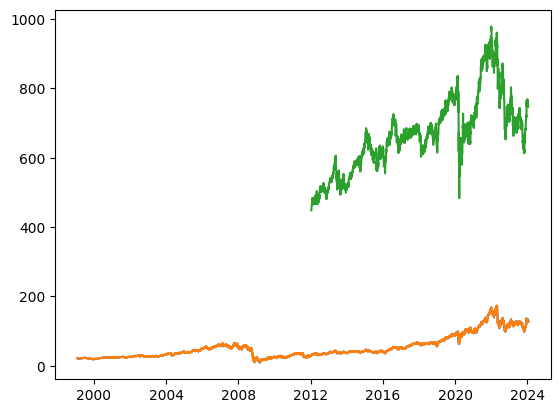

In [ ]:
plt.plot(PLD['date'],PLD['close']);
plt.plot(PLD['date'],PLD['open']);
plt.plot(FNER_NAREIT_index['Date'],FNER_NAREIT_index['Open']);

In [ ]:
import yfinance as yf

In [ ]:
FNER_raw = yf.Ticker("^FNER")

In [ ]:
FNER =  pd.DataFrame(FNER_raw.history(period="Max"))
FNER.reset_index(inplace=True)

In [ ]:
FNER

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2012-01-12 00:00:00+00:00,451.559998,451.869995,445.859985,446.269989,0,0.0,0.0
1,2012-01-13 00:00:00+00:00,448.820007,449.019989,444.589996,448.260010,0,0.0,0.0
2,2012-01-16 00:00:00+00:00,449.880005,449.880005,449.880005,449.880005,0,0.0,0.0
3,2012-01-17 00:00:00+00:00,449.880005,456.070007,449.880005,455.899994,0,0.0,0.0
4,2012-01-18 00:00:00+00:00,453.089996,457.380005,453.040009,456.000000,0,0.0,0.0
...,...,...,...,...,...,...,...,...
3000,2024-01-15 00:00:00+00:00,746.750000,756.150024,746.750000,751.750000,0,0.0,0.0
3001,2024-01-16 00:00:00+00:00,751.750000,751.750000,745.320007,745.960022,0,0.0,0.0
3002,2024-01-17 00:00:00+00:00,746.729980,746.729980,725.049988,727.820007,0,0.0,0.0
3003,2024-01-18 00:00:00+00:00,732.570007,734.950012,722.809998,726.320007,0,0.0,0.0


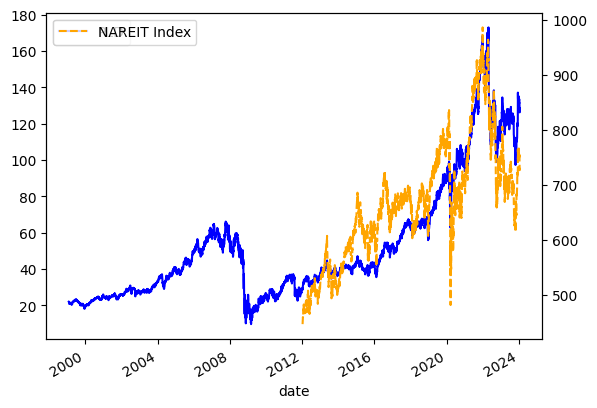

In [ ]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
PLD.plot(x="date",y="close",ax=ax,color='blue',label='PLD');
FNER.plot(x="Date",y="Close",ax=ax2, ls="--", color="orange",label='NAREIT Index');

KeyboardInterrupt: 

Exception ignored in: 'pandas._libs.tslibs.timezones.is_utc_zoneinfo'
Traceback (most recent call last):
  File "C:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\zoneinfo\_common.py", line 12, in load_tzdata
    return resources.files(package_name).joinpath(resource_name).open("rb")
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\importlib\resources\_common.py", line 22, in files
    return from_package(get_package(package))
                        ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\importlib\resources\_common.py", line 53, in get_package
    resolved = resolve(package)
               ^^^^^^^^^^^^^^^^
  File "C:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\importlib\resources\_common.py", line 44, in resolve
    return cand if isinstance(cand, types.ModuleType) else importlib.import_module(cand)
                                                           ^^^^^^^^^^^^

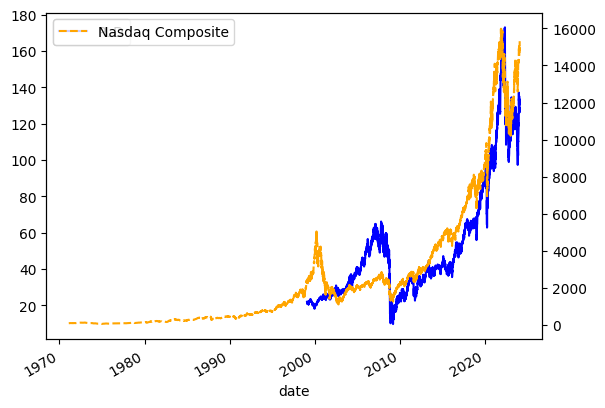

In [ ]:
NASDAQ_Composite_raw = yf.Ticker("^IXIC")
IXIC =  pd.DataFrame(NASDAQ_Composite_raw.history(period="Max"))
IXIC.reset_index(inplace=True)


fig, ax = plt.subplots()
ax2 = ax.twinx()
PLD.plot(x="date",y="close",ax=ax,color='blue',label='PLD');
IXIC.plot(x="Date",y="Close",ax=ax2, ls="--", color="orange",label='Nasdaq Composite');

In [ ]:
PLD.columns

Index(['date', 'open', 'high', 'low', 'close', 'adjClose', 'volume',
       'unadjustedVolume', 'change', 'changePercent',
       ...
       'returnOnTangibleAssets', 'revenuePerShare', 'roe', 'roic',
       'salesGeneralAndAdministrativeToRevenue', 'shareholdersEquityPerShare',
       'stockBasedCompensationToRevenue', 'tangibleAssetValue',
       'tangibleBookValuePerShare', 'workingCapital'],
      dtype='object', length=178)

In [19]:
x_train = np.array(PLD['date'].map(dt.datetime.toordinal),dtype=np.float32)
x_train = x_train.reshape(-1,1)
y_train = np.array(PLD['close'],dtype=np.float32)
y_train = y_train.reshape(-1,1)

Neural Network

In [20]:
recasted_PLD = PLD
recasted_PLD['date'] = recasted_PLD['date'].map(dt.datetime.toordinal)
x_train = np.array(recasted_PLD[['date','open']],dtype=np.float32)
x_train = x_train.reshape(-1,2)
y_train = np.array(recasted_PLD['close'],dtype=np.float32)
y_train = y_train.reshape(-1,1)

### 2 Layer 2 input NN

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim

# Assuming x_train is a 2D array with two features and y_train is the target array
X = torch.tensor(x_train, dtype=torch.float32)
Y = torch.tensor(y_train, dtype=torch.float32)

# Normalizing data
X_mean, X_std = X.mean(0), X.std(0)
Y_mean, Y_std = Y.mean(), Y.std()

X_norm = (X - X_mean) / X_std
Y_norm = (Y - Y_mean) / Y_std

# Neural Network Model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(2, 10)  # Input layer to first hidden layer
        self.relu = nn.ReLU()        # Activation function
        self.fc2 = nn.Linear(10, 1)  # Second hidden layer to output layer

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = NeuralNetwork()

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training the model
epochs = 1000
for epoch in range(epochs):
    optimizer.zero_grad()
    Y_pred = model(X_norm)
    loss = criterion(Y_pred, Y_norm)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

# Testing the model
model.eval()
with torch.no_grad():
    predicted = model(X_norm).numpy() * Y_std.numpy() + Y_mean.numpy()

print(predicted)

Epoch 1/1000, Loss: 1.611741304397583
Epoch 101/1000, Loss: 0.08002237975597382
Epoch 201/1000, Loss: 0.045907266438007355
Epoch 301/1000, Loss: 0.03296523541212082
Epoch 401/1000, Loss: 0.02473362162709236
Epoch 501/1000, Loss: 0.0186658576130867
Epoch 601/1000, Loss: 0.013974118046462536
Epoch 701/1000, Loss: 0.01035365741699934
Epoch 801/1000, Loss: 0.007623207289725542
Epoch 901/1000, Loss: 0.005618599243462086
[[129.22806 ]
 [128.95222 ]
 [128.84909 ]
 ...
 [ 22.526682]
 [ 22.433863]
 [ 22.478899]]


In [24]:
X_norm

tensor([[ 1.7321,  2.2371],
        [ 1.7318,  2.2281],
        [ 1.7314,  2.2248],
        ...,
        [-1.7308, -0.9247],
        [-1.7312, -0.9283],
        [-1.7316, -0.9265]])

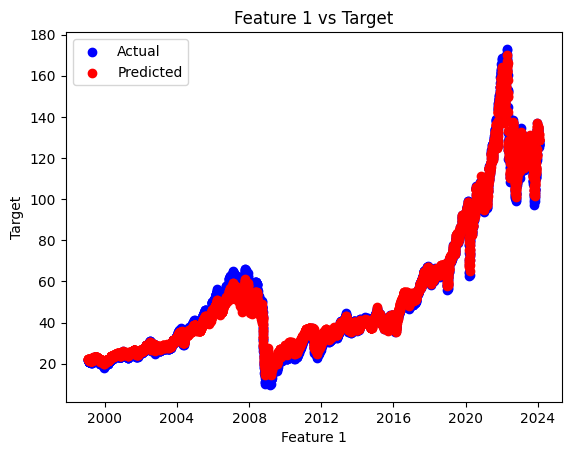

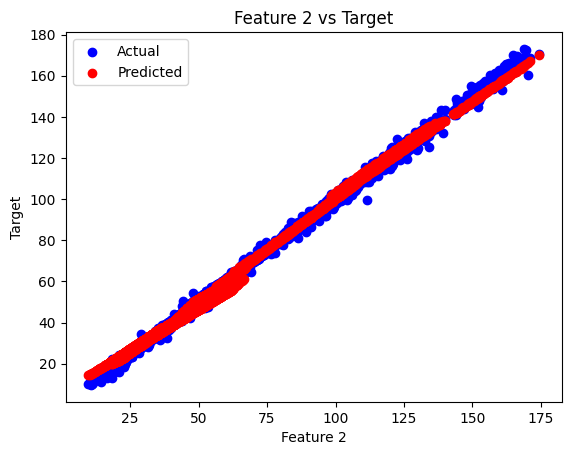

In [23]:
import matplotlib.pyplot as plt

# Assuming x_train is a 2D array with two features and y_train is the target array

# Converting predictions to numpy for easy plotting
predicted_numpy = predicted.squeeze()

# Plot for Feature 1
x_train_date = list(map(dt.date.fromordinal,x_train[:, 0].astype(int)))
plt.scatter(x_train_date, y_train, label='Actual', color='blue')
plt.scatter(x_train_date, predicted_numpy, label='Predicted', color='red')
plt.xlabel('Feature 1')
plt.ylabel('Target')
plt.title('Feature 1 vs Target')
plt.legend()
plt.show()

# Plot for Feature 2
plt.scatter(x_train[:, 1], y_train, label='Actual', color='blue')
plt.scatter(x_train[:, 1], predicted_numpy, label='Predicted', color='red')
plt.xlabel('Feature 2')
plt.ylabel('Target')
plt.title('Feature 2 vs Target')
plt.legend()
plt.show()

In [ ]:
recasted_PLD = PLD
#recasted_PLD['date'] = recasted_PLD['date'].map(dt.datetime.toordinal)
x_train = np.array(recasted_PLD[['date','open']],dtype=np.float32)
x_train = x_train.reshape(-1,2)
y_train = np.array(recasted_PLD['close'],dtype=np.float32)
y_train = y_train.reshape(-1,1)

In [ ]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
PLD_only_numeric = recasted_PLD.select_dtypes(include=numerics)

In [ ]:
PLD_only_numeric

,date,open,high,low,close,adjClose,volume,unadjustedVolume,change,changePercent,vwap,changeOverTime,costAndExpenses,costOfRevenue,depreciationAndAmortization,ebitda,ebitdaratio,eps,epsdiluted,generalAndAdministrativeExpenses,grossProfit,grossProfitRatio,incomeBeforeTax,incomeBeforeTaxRatio,incomeTaxExpense,interestExpense,interestIncome,netIncome,netIncomeRatio,operatingExpenses,operatingIncome,operatingIncomeRatio,otherExpenses,researchAndDevelopmentExpenses,revenue,sellingAndMarketingExpenses,sellingGeneralAndAdministrativeExpenses,totalOtherIncomeExpensesNet,weightedAverageShsOut,weightedAverageShsOutDil,accountPayables,accumulatedOtherComprehensiveIncomeLoss,capitalLeaseObligations,cashAndCashEquivalents,cashAndShortTermInvestments,commonStock,deferredRevenue,deferredRevenueNonCurrent,deferredTaxLiabilitiesNonCurrent,goodwill,goodwillAndIntangibleAssets,intangibleAssets,inventory,longTermDebt,longTermInvestments,minorityInterest,netDebt,netReceivables,otherAssets,otherCurrentAssets,otherCurrentLiabilities,otherLiabilities,otherNonCurrentAssets,otherNonCurrentLiabilities,othertotalStockholdersEquity,preferredStock,propertyPlantEquipmentNet,retainedEarnings,shortTermDebt,shortTermInvestments,taxAssets,taxPayables,totalAssets,totalCurrentAssets,totalCurrentLiabilities,totalDebt,totalEquity,totalInvestments,totalLiabilities,totalLiabilitiesAndStockholdersEquity,totalLiabilitiesAndTotalEquity,totalNonCurrentAssets,totalNonCurrentLiabilities,totalStockholdersEquity,accountsPayables,accountsReceivables,acquisitionsNet,capitalExpenditure,cashAtBeginningOfPeriod,cashAtEndOfPeriod,changeInWorkingCapital,commonStockIssued,commonStockRepurchased,debtRepayment,deferredIncomeTax,dividendsPaid,effectOfForexChangesOnCash,freeCashFlow,investmentsInPropertyPlantAndEquipment,netCashProvidedByOperatingActivities,netCashUsedForInvestingActivites,netCashUsedProvidedByFinancingActivities,netChangeInCash,operatingCashFlow,otherFinancingActivites,otherInvestingActivites,otherNonCashItems,otherWorkingCapital,purchasesOfInvestments,salesMaturitiesOfInvestments,stockBasedCompensation,averageInventory,averagePayables,averageReceivables,bookValuePerShare,capexPerShare,capexToDepreciation,capexToOperatingCashFlow,capexToRevenue,cashPerShare,currentRatio,daysOfInventoryOnHand,daysPayablesOutstanding,daysSalesOutstanding,debtToAssets,debtToEquity,dividendYield,earningsYield,enterpriseValue,enterpriseValueOverEBITDA,evToFreeCashFlow,evToOperatingCashFlow,evToSales,freeCashFlowPerShare,freeCashFlowYield,grahamNetNet,grahamNumber,incomeQuality,intangiblesToTotalAssets,interestCoverage,interestDebtPerShare,inventoryTurnover,investedCapital,marketCap,netCurrentAssetValue,netDebtToEBITDA,netIncomePerShare,operatingCashFlowPerShare,payablesTurnover,payoutRatio,pbRatio,peRatio,pfcfRatio,pocfratio,priceToSalesRatio,ptbRatio,receivablesTurnover,researchAndDdevelopementToRevenue,returnOnTangibleAssets,revenuePerShare,roe,roic,salesGeneralAndAdministrativeToRevenue,shareholdersEquityPerShare,stockBasedCompensationToRevenue,tangibleAssetValue,tangibleBookValuePerShare,workingCapital
0,738904,126.92,128.870,126.060,128.44,128.44,3558857,3555913,1.52,1.20000,127.79,0.012000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,738903,126.79,127.250,124.665,126.26,126.26,4062956,4062900,-0.53,-0.41801,125.95,-0.004180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [12]:
PLD_only_numeric_no_nan = 0
for column in PLD_only_numeric.columns:
    PLD_only_numeric_no_nan = PLD_only_numeric[PLD_only_numeric[column].notna()]

NameError: name 'PLD_only_numeric' is not defined

In [13]:
PLD_only_numeric_no_nan

0

In [ ]:
PLD_only_numeric_x_train = np.array(PLD_only_numeric_no_nan.drop(['close'],axis=1),dtype=np.float32)

In [ ]:
y_train = np.array(PLD_only_numeric_no_nan['close'],dtype=np.float32)

In [ ]:
PLD_only_numeric_x_train

array([[ 7.3879200e+05,  1.1404000e+02,  1.1413000e+02, ...,
         5.8260861e+10,  6.3025940e+01, -3.9525699e+08],
       [ 7.3879100e+05,  1.1201000e+02,  1.1316000e+02, ...,
         5.8260861e+10,  6.3025940e+01, -3.9525699e+08],
       [ 7.3879000e+05,  1.1213000e+02,  1.1264000e+02, ...,
         5.8260861e+10,  6.3025940e+01, -3.9525699e+08],
       ...,
       [ 7.2978800e+05,  2.2059999e+01,  2.2059999e+01, ...,
         2.0863930e+09,  2.4260101e+01,  3.3312000e+07],
       [ 7.2978700e+05,  2.1940001e+01,  2.2059999e+01, ...,
         2.0863930e+09,  2.4260101e+01,  3.3312000e+07],
       [ 7.2978600e+05,  2.2000000e+01,  2.2190001e+01, ...,
         2.0863930e+09,  2.4260101e+01,  3.3312000e+07]], dtype=float32)

In [ ]:
len(y_train)

6207

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Assuming x_train is a 2D array with 167 features and y_train is the target array
X = torch.tensor(PLD_only_numeric_x_train, dtype=torch.float32)
Y = torch.tensor(y_train, dtype=torch.float32)

# Normalizing data (with epsilon to avoid division by zero)
epsilon = 1e-8
X_mean, X_std = X.mean(0, keepdim=True), X.std(0, unbiased=False, keepdim=True)
Y_mean, Y_std = Y.mean(), Y.std()

X_norm = (X - X_mean) / (X_std + epsilon)
Y_norm = (Y - Y_mean) / (Y_std + epsilon)

# Neural Network Model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(167, 128)  # First hidden layer
        self.fc2 = nn.Linear(128, 64)   # Second hidden layer
        self.fc3 = nn.Linear(64, 32)    # Third hidden layer
        self.fc4 = nn.Linear(32, 1)     # Output layer
        self.relu = nn.ReLU()           # Activation function

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

model = NeuralNetwork()

# Loss function and optimizer
# Starting with a conservative learning rate
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Training the model
epochs = 5000
for epoch in range(epochs):
    optimizer.zero_grad()
    Y_pred = model(X_norm)
    loss = criterion(Y_pred, Y_norm)
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')
        if torch.isnan(loss).item():
            print("Loss is NaN. Stopping training.")
            break

# Evaluate the model
model.eval()
with torch.no_grad():
    predicted = model(X_norm).numpy() * Y_std.numpy() + Y_mean.numpy()

print(predicted)

C:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([6207])) that is different to the input size (torch.Size([6207, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/5000, Loss: 1144124211200.0
Epoch 501/5000, Loss: 1.0000406503677368
Epoch 1001/5000, Loss: 1.0000009536743164
Epoch 1501/5000, Loss: 0.9999784231185913
Epoch 2001/5000, Loss: 0.9999882578849792
Epoch 2501/5000, Loss: 0.9999717473983765
Epoch 3001/5000, Loss: 0.9999728202819824
Epoch 3501/5000, Loss: 0.9999777674674988
Epoch 4001/5000, Loss: 0.9999762177467346
Epoch 4501/5000, Loss: 0.9999833106994629
[[51.572994]
 [52.08251 ]
 [51.82775 ]
 ...
 [52.337273]
 [51.572994]
 [51.572994]]


In [ ]:
len(X_norm)

6207

In [ ]:
len(X)

6207

In [ ]:
len(predicted)

6207

In [ ]:
X_norm.numpy()

array([[ 1.7314774 ,  1.9026341 ,  1.8695238 , ...,  2.9985168 ,
         2.000285  , -0.5448519 ],
       [ 1.7310928 ,  1.8404056 ,  1.8400886 , ...,  2.9985168 ,
         2.000285  , -0.5448519 ],
       [ 1.7307082 ,  1.8440839 ,  1.8243086 , ...,  2.9985168 ,
         2.000285  , -0.5448519 ],
       ...,
       [-1.7309005 , -0.9169657 , -0.9244083 , ..., -0.75261146,
        -0.29667687,  0.03832813],
       [-1.7312851 , -0.9206442 , -0.9244083 , ..., -0.75261146,
        -0.29667687,  0.03832813],
       [-1.7316697 , -0.91880494, -0.9204633 , ..., -0.75261146,
        -0.29667687,  0.03832813]], dtype=float32)

In [ ]:
predicted

array([[51.572994],
       [52.08251 ],
       [51.82775 ],
       ...,
       [52.337273],
       [51.572994],
       [51.572994]], dtype=float32)

In [ ]:
Y

tensor([112.2100, 112.1300, 111.2500,  ...,  22.0000,  22.0600,  22.0600])

In [ ]:
x_train

array([[7.38904e+05, 1.26920e+02],
       [7.38903e+05, 1.26790e+02],
       [7.38902e+05, 1.27940e+02],
       ...,
       [7.29788e+05, 2.20600e+01],
       [7.29787e+05, 2.19400e+01],
       [7.29786e+05, 2.20000e+01]], dtype=float32)

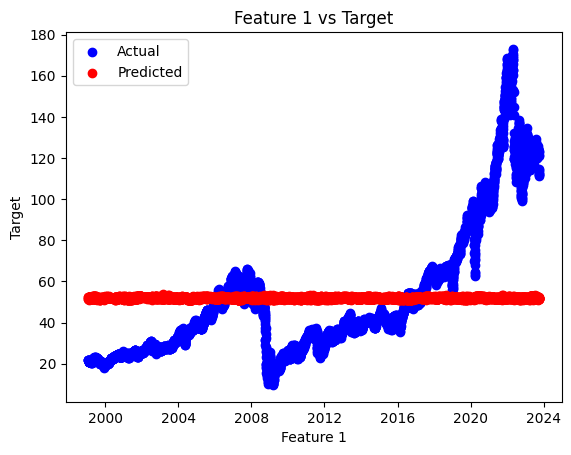

In [ ]:
import matplotlib.pyplot as plt

# Assuming x_train is a 2D array with two features and y_train is the target array

# Converting predictions to numpy for easy plotting
predicted_numpy = predicted.squeeze()

# Plot for Feature 1
x_train_date = list(map(dt.date.fromordinal,X.numpy()[:, 0].astype(int)))
plt.scatter(x_train_date, y_train, label='Actual', color='blue')
plt.scatter(x_train_date, predicted_numpy, label='Predicted', color='red')
plt.xlabel('Feature 1')
plt.ylabel('Target')
plt.title('Feature 1 vs Target')
plt.legend()
plt.show()

### Selected 22 features

In [12]:
PLD_training_set['date'] = PLD_training_set['date'].map(dt.datetime.toordinal)
PLD_training_set

C:\Users\pc\AppData\Local\Temp\ipykernel_23180\2817832065.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PLD_training_set['date'] = PLD_training_set['date'].map(dt.datetime.toordinal)


,date,open,high,low,close,volume,vwap,netIncome,totalAssets,totalCurrentAssets,totalDebt,totalCurrentLiabilities,totalEquity,netIncome,netCashProvidedByOperatingActivities,netCashUsedForInvestingActivites,netCashUsedProvidedByFinancingActivities,netChangeInCash,capitalExpenditure,cashPerShare,currentRatio,returnOnTangibleAssets,earningsYield
84,738792,114.04,114.13,111.45,112.21,3414600,112.60,746174000.0,9.194941e+10,1.538599e+09,2.757820e+10,1.933856e+09,5.826086e+10,746174000.0,1.969201e+09,-698947000.0,-1.047659e+09,209731000.0,-16513000.0,0.801433,0.795612,0.008131,0.007208
85,738791,112.01,113.16,111.29,112.13,2177000,112.19,746174000.0,9.194941e+10,1.538599e+09,2.757820e+10,1.933856e+09,5.826086e+10,746174000.0,1.969201e+09,-698947000.0,-1.047659e+09,209731000.0,-16513000.0,0.801433,0.795612,0.008131,0.007208
86,738790,112.13,112.64,110.84,111.25,3226600,111.58,746174000.0,9.194941e+10,1.538599e+09,2.757820e+10,1.933856e+09,5.826086e+10,746174000.0,1.969201e+09,-698947000.0,-1.047659e+09,209731000.0,-16513000.0,0.801433,0.795612,0.008131,0.007208
87,738789,112.10,113.06,111.00,111.50,3179200,111.85,746174000.0,9.194941e+10,1.538599e+09,2.757820e+10,1.933856e+09,5.826086e+10,746174000.0,1.969201e+09,-698947000.0,-1.047659e+09,209731000.0,-16513000.0,0.801433,0.795612,0.008131,0.007208
88,738788,113.45,113.90,112.39,113.25,3221000,113.18,746174000.0,9.194941e+10,1.538599e+09,2.757820e+10,1.933856e+09,5.826086e+10,746174000.0,1.969201e+09,-698947000.0,-1.047659e+09,209731000.0,-16513000.0,0.801433,0.795612,0.008131,0.007208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6286,729790,21.94,21.94,21.75,21.81,29500,21.83,28014000.0,3.696618e+09,3.331200e+07,1.486429e+09,7.331000e+07,1.761533e+09,28014000.0,6.451200e+07,-100199000.0,3.971500e+07,4028000.0,-101308000.0,0.386128,3.152080,0.007578,0.015698
6287,729789,21.94,22.00,21.88,21.94,100600,21.94,28014000.0,3.696618e+09,3.331200e+07,1.486429e+09,7.331000e+07,1.761533e+09,28014000.0,6.451200e+07,-100199000.0,3.971500e+07,4028000.0,-101308000.0,0.386128,3.152080,0.007578,0.015698
6288,729788,22.06,22.06,21.94,22.00,33400,22.00,28014000.0,3.696618e+09,3.331200e+07,1.486429e+09,7.331000e+07,1.761533e+09,28014000.0,6.451200e+07,-100199000.0,3.971500e+07,4028000.0,-101308000.0,0.386128,3.152080,0.007578,0.015698
6289,729787,21.94,22.06,21.94,22.06,80600,22.02,28014000.0,3.696618e+09,3.331200e+07,1.486429e+09,7.331000e+07,1.761533e+09,28014000.0,6.451200e+07,-100199000.0,3.971500e+07,4028000.0,-101308000.0,0.386128,3.152080,0.007578,0.015698


In [ ]:
PLD_wonan_x_train = np.array(PLD_training_set.drop(['close'],axis=1),dtype=np.float32)

In [ ]:
y_train = np.array(PLD_training_set['close'],dtype=np.float32)

In [ ]:
len(PLD_wonan_x_train)

5

In [ ]:
len(y_train)

6207

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Assuming x_train is a 2D array with 23 features and y_train is the target array
X = torch.tensor(PLD_wonan_x_train, dtype=torch.float32)
Y = torch.tensor(y_train, dtype=torch.float32)

# Normalizing data (with epsilon to avoid division by zero)
epsilon = 1e-8
X_mean, X_std = X.mean(0, keepdim=True), X.std(0, unbiased=False, keepdim=True)
Y_mean, Y_std = Y.mean(), Y.std()

X_norm = (X - X_mean) / (X_std + epsilon)
Y_norm = (Y - Y_mean) / (Y_std + epsilon)

# Neural Network Model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(22, 17)  # First hidden layer
        self.fc2 = nn.Linear(17, 8)   # Second hidden layer
        self.fc3 = nn.Linear(8, 3)    # Third hidden layer
        self.fc4 = nn.Linear(3, 1)     # Output layer
        self.relu = nn.ReLU()           # Activation function

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

model = NeuralNetwork()

# Loss function and optimizer
# Starting with a conservative learning rate
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Training the model
epochs = 5000
for epoch in range(epochs):
    optimizer.zero_grad()
    Y_pred = model(X_norm)
    loss = criterion(Y_pred, Y_norm)
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')
        if torch.isnan(loss).item():
            print("Loss is NaN. Stopping training.")
            break

# Evaluate the model
model.eval()
with torch.no_grad():
    predicted = model(X_norm).numpy() * Y_std.numpy() + Y_mean.numpy()

print(predicted)

/Users/joykwok/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([6207])) that is different to the input size (torch.Size([6207, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/5000, Loss: 1.033105492591858
Epoch 501/5000, Loss: 0.9999046921730042
Epoch 1001/5000, Loss: 0.9998486042022705
Epoch 1501/5000, Loss: 0.9998424053192139
Epoch 2001/5000, Loss: 0.999840497970581
Epoch 2501/5000, Loss: 0.9998399019241333
Epoch 3001/5000, Loss: 0.9998396039009094
Epoch 3501/5000, Loss: 0.9998394846916199
Epoch 4001/5000, Loss: 0.9998393654823303
Epoch 4501/5000, Loss: 0.9998393058776855
[[51.95151 ]
 [51.934025]
 [51.945023]
 ...
 [51.9515  ]
 [51.951725]
 [51.95208 ]]


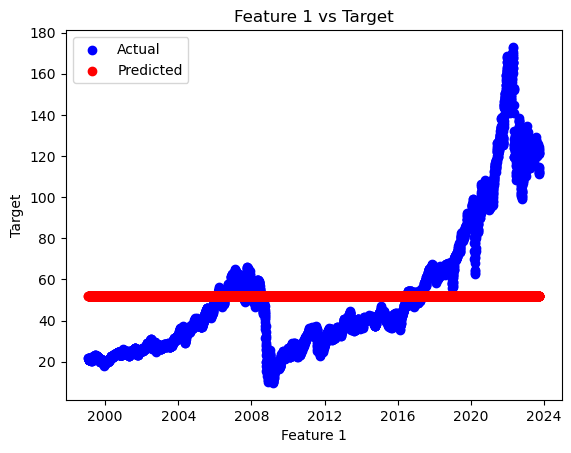

In [ ]:
import matplotlib.pyplot as plt

# Assuming x_train is a 2D array with two features and y_train is the target array

# Converting predictions to numpy for easy plotting
predicted_numpy = predicted.squeeze()

# Plot for Feature 1
x_train_date = list(map(dt.date.fromordinal,X.numpy()[:, 0].astype(int)))
plt.scatter(x_train_date, y_train, label='Actual', color='blue')
plt.scatter(x_train_date, predicted_numpy, label='Predicted', color='red')
plt.xlabel('Feature 1')
plt.ylabel('Target')
plt.title('Feature 1 vs Target')
plt.legend()
plt.show()

In [ ]:
# 22 features also resulted in seemingly erronous straight line prediction

In [13]:
PLD_training_set

,date,open,high,low,close,volume,vwap,netIncome,totalAssets,totalCurrentAssets,totalDebt,totalCurrentLiabilities,totalEquity,netIncome,netCashProvidedByOperatingActivities,netCashUsedForInvestingActivites,netCashUsedProvidedByFinancingActivities,netChangeInCash,capitalExpenditure,cashPerShare,currentRatio,returnOnTangibleAssets,earningsYield
84,738792,114.04,114.13,111.45,112.21,3414600,112.60,746174000.0,9.194941e+10,1.538599e+09,2.757820e+10,1.933856e+09,5.826086e+10,746174000.0,1.969201e+09,-698947000.0,-1.047659e+09,209731000.0,-16513000.0,0.801433,0.795612,0.008131,0.007208
85,738791,112.01,113.16,111.29,112.13,2177000,112.19,746174000.0,9.194941e+10,1.538599e+09,2.757820e+10,1.933856e+09,5.826086e+10,746174000.0,1.969201e+09,-698947000.0,-1.047659e+09,209731000.0,-16513000.0,0.801433,0.795612,0.008131,0.007208
86,738790,112.13,112.64,110.84,111.25,3226600,111.58,746174000.0,9.194941e+10,1.538599e+09,2.757820e+10,1.933856e+09,5.826086e+10,746174000.0,1.969201e+09,-698947000.0,-1.047659e+09,209731000.0,-16513000.0,0.801433,0.795612,0.008131,0.007208
87,738789,112.10,113.06,111.00,111.50,3179200,111.85,746174000.0,9.194941e+10,1.538599e+09,2.757820e+10,1.933856e+09,5.826086e+10,746174000.0,1.969201e+09,-698947000.0,-1.047659e+09,209731000.0,-16513000.0,0.801433,0.795612,0.008131,0.007208
88,738788,113.45,113.90,112.39,113.25,3221000,113.18,746174000.0,9.194941e+10,1.538599e+09,2.757820e+10,1.933856e+09,5.826086e+10,746174000.0,1.969201e+09,-698947000.0,-1.047659e+09,209731000.0,-16513000.0,0.801433,0.795612,0.008131,0.007208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6286,729790,21.94,21.94,21.75,21.81,29500,21.83,28014000.0,3.696618e+09,3.331200e+07,1.486429e+09,7.331000e+07,1.761533e+09,28014000.0,6.451200e+07,-100199000.0,3.971500e+07,4028000.0,-101308000.0,0.386128,3.152080,0.007578,0.015698
6287,729789,21.94,22.00,21.88,21.94,100600,21.94,28014000.0,3.696618e+09,3.331200e+07,1.486429e+09,7.331000e+07,1.761533e+09,28014000.0,6.451200e+07,-100199000.0,3.971500e+07,4028000.0,-101308000.0,0.386128,3.152080,0.007578,0.015698
6288,729788,22.06,22.06,21.94,22.00,33400,22.00,28014000.0,3.696618e+09,3.331200e+07,1.486429e+09,7.331000e+07,1.761533e+09,28014000.0,6.451200e+07,-100199000.0,3.971500e+07,4028000.0,-101308000.0,0.386128,3.152080,0.007578,0.015698
6289,729787,21.94,22.06,21.94,22.06,80600,22.02,28014000.0,3.696618e+09,3.331200e+07,1.486429e+09,7.331000e+07,1.761533e+09,28014000.0,6.451200e+07,-100199000.0,3.971500e+07,4028000.0,-101308000.0,0.386128,3.152080,0.007578,0.015698


In [14]:
PLD_wonan_x_train = np.array(PLD_training_set[PLD_training_set.columns.tolist()[:5]].drop(['close'],axis=1),dtype=np.float32)

In [15]:
y_train = np.array(PLD_training_set['close'],dtype=np.float32)

In [16]:
PLD_wonan_x_train

array([[7.38792e+05, 1.14040e+02, 1.14130e+02, 1.11450e+02],
       [7.38791e+05, 1.12010e+02, 1.13160e+02, 1.11290e+02],
       [7.38790e+05, 1.12130e+02, 1.12640e+02, 1.10840e+02],
       ...,
       [7.29788e+05, 2.20600e+01, 2.20600e+01, 2.19400e+01],
       [7.29787e+05, 2.19400e+01, 2.20600e+01, 2.19400e+01],
       [7.29786e+05, 2.20000e+01, 2.21900e+01, 2.20000e+01]],
      dtype=float32)

In [21]:
len(PLD_wonan_x_train)

6207

In [22]:
len(y_train)

6207

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim

# Assuming x_train is a 2D array with 23 features and y_train is the target array
X = torch.tensor(PLD_wonan_x_train, dtype=torch.float32)
Y = torch.tensor(y_train, dtype=torch.float32)

# Normalizing data (with epsilon to avoid division by zero)
epsilon = 1e-8
X_mean, X_std = X.mean(0, keepdim=True), X.std(0, unbiased=False, keepdim=True)
Y_mean, Y_std = Y.mean(), Y.std()

X_norm = (X - X_mean) / (X_std + epsilon)
Y_norm = (Y - Y_mean) / (Y_std + epsilon)

# Neural Network Model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(4, 2)  # Input layer to first hidden layer
        self.relu = nn.ReLU()        # Activation function
        self.fc2 = nn.Linear(2, 1)  # Second hidden layer to output layer

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = NeuralNetwork()

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training the model
epochs = 1000
for epoch in range(epochs):
    optimizer.zero_grad()
    Y_pred = model(X_norm)
    loss = criterion(Y_pred, Y_norm)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

# Testing the model
model.eval()
with torch.no_grad():
    predicted = model(X_norm).numpy() * Y_std.numpy() + Y_mean.numpy()

print(predicted)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([6207])) that is different to the input size (torch.Size([6207, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/1000, Loss: 1.5365012884140015
Epoch 101/1000, Loss: 1.0081685781478882
Epoch 201/1000, Loss: 1.0000207424163818
Epoch 301/1000, Loss: 0.999885082244873
Epoch 401/1000, Loss: 0.9998799562454224
Epoch 501/1000, Loss: 0.9998771548271179
Epoch 601/1000, Loss: 0.9998747110366821
Epoch 701/1000, Loss: 0.9998723864555359
Epoch 801/1000, Loss: 0.9998703002929688
Epoch 901/1000, Loss: 0.9998684525489807
[[52.13967 ]
 [52.13967 ]
 [52.13967 ]
 ...
 [51.775116]
 [51.776573]
 [51.77844 ]]


In [17]:
import torch
import torch.nn as nn
import torch.optim as optim

# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming x_train is a 2D array with 23 features and y_train is the target array
X = torch.tensor(PLD_wonan_x_train, dtype=torch.float32).to(device)
Y = torch.tensor(y_train, dtype=torch.float32).to(device)

# Normalizing data (with epsilon to avoid division by zero)
epsilon = 1e-8
X_mean, X_std = X.mean(0, keepdim=True), X.std(0, unbiased=False, keepdim=True)
Y_mean, Y_std = Y.mean(), Y.std()

X_norm = (X - X_mean) / (X_std + epsilon)
Y_norm = (Y - Y_mean) / (Y_std + epsilon)

# Neural Network Model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(4, 2)  # Input layer to first hidden layer
        self.relu = nn.ReLU()       # Activation function
        self.fc2 = nn.Linear(2, 1)  # Second hidden layer to output layer

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = NeuralNetwork().to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training the model
epochs = 1000
for epoch in range(epochs):
    optimizer.zero_grad()
    Y_pred = model(X_norm)
    loss = criterion(Y_pred, Y_norm)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

# Testing the model
model.eval()
with torch.no_grad():
    predicted = model(X_norm).cpu().numpy() * Y_std.cpu().numpy() + Y_mean.cpu().numpy()

print(predicted)

C:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([6207])) that is different to the input size (torch.Size([6207, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/1000, Loss: 1.0513123273849487
Epoch 101/1000, Loss: 1.0055657625198364
Epoch 201/1000, Loss: 1.003382682800293
Epoch 301/1000, Loss: 1.0021744966506958
Epoch 401/1000, Loss: 1.0014337301254272
Epoch 501/1000, Loss: 1.0009633302688599
Epoch 601/1000, Loss: 1.0006561279296875
Epoch 701/1000, Loss: 1.000450849533081
Epoch 801/1000, Loss: 1.0003104209899902
Epoch 901/1000, Loss: 1.0002121925354004
[[52.30587 ]
 [52.412132]
 [52.422512]
 ...
 [51.784527]
 [51.786503]
 [51.771507]]


In [ ]:
import matplotlib.pyplot as plt

# Assuming x_train is a 2D array with two features and y_train is the target array

# Converting predictions to numpy for easy plotting
predicted_numpy = predicted.squeeze()

# Plot for Feature 1
x_train_date = list(map(dt.date.fromordinal,X.numpy()[:, 0].astype(int)))
plt.scatter(x_train_date, y_train, label='Actual', color='blue')
plt.scatter(x_train_date, predicted_numpy, label='Predicted', color='red')
plt.xlabel('Feature 1')
plt.ylabel('Target')
plt.title('Feature 1 vs Target')
plt.legend()
plt.show()